# Develop a method for harmonizing data from OzWALD

Data is here: https://dapds00.nci.org.au/thredds/catalog/ub8/au/catalog.html

Requirements:
* Must be reproducible in an operational context i.e. minumum of fuss to rerun the whole process each year, but first off we need a ~20yr archive to build the models and run historic predictions
* For now, run at 5 km resolution
* Intermediate files are fine, but lets keep the number of steps to a minimum
* Some variables are already computed by OzWALD, but others need to be either computed on-the-fly or saved and stored as intermediate files.
* Many of the pre-computed variables available in OzWALD require resampling spatially and temporally
* A python environment is required, but should be a small as possible (but will undoubtedly still be cumbersome)
* There is a soft requirement that the model be built on features as close to possible as the published 'AusEFlux' article in Biogeosciences.



In [1]:
import os
import pandas as pd
import xarray as xr
import numpy as np
from odc.geo.xr import assign_crs
from odc.geo.geobox import zoom_out

import warnings
warnings.simplefilter(action='ignore')

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import start_local_dask, round_coords

In [2]:
client = start_local_dask(mem_safety_margin='2Gb')
client

distributed.nanny.memory - WARNING - Ignoring provided memory limit 200468745216 due to system memory limit of 95.00 GiB
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configurati

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 24,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34763,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 95.00 GiB
Comm: tcp://127.0.0.1:40757,Total threads: 24
Dashboard: /proxy/39529/status,Memory: 95.00 GiB
Nanny: tcp://127.0.0.1:42505,


In [3]:
base = '/g/data/ub8/au/'
results='/g/data/os22/chad_tmp/AusEFlux/data/interim/'
years = [str(i) for i in range(2003,2023)]

## Grab a common grid to reproject too and a create a land mask

In [4]:
gbox = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/WCF_5km_monthly_1982_2022.nc').odc.geobox
gbox

#create a mask of aus extent
mask = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/WCF_5km_monthly_1982_2022.nc')['WCF']
mask = mask.mean('time')
mask = xr.where(mask>-99, 1, 0)

## Process MODIS Surface Reflectance into NDWI

This will give us NDWI

This takes ~9-10 mins per year to process using 24 cores

In [ ]:
chunks=dict(latitude=1000, longitude=1000, time=1)

#loop through each year
for year in years:

    modis_sr_inputs = {
        'SR_B2': 'MODIS/mosaic/MCD43A4.006/MCD43A4.006.b02.500m_0841_0876nm_nbar.'+year+'.nc',
        'SR_B5': 'MODIS/mosaic/MCD43A4.006/MCD43A4.006.b05.500m_1230_1250nm_nbar.'+year+'.nc',
         }
    
    d = {}
    for k,i in modis_sr_inputs.items():
        
        if os.path.exists(results+'NDWI'+'/NDWI_5km_'+year+'.nc'):
            continue
        else:
            print(k, year)
        
        #open and do some prelim processing
        ds = xr.open_dataset(base+i, chunks=chunks)
        ds = assign_crs(ds, crs='epsg:4326')
        ds = ds.to_array()
        ds = ds.squeeze().drop_vars('variable')
        ds.attrs['nodata'] = np.nan
        ds = ds.rename(k)        
        d[k] = ds #add to dict

    #calculate NDWI 
    ndwi = (d['SR_B2'] - d['SR_B5']) / (d['SR_B2'] + d['SR_B5'])

    #resample time
    ndwi = ndwi.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean().persist()

    # resample spatial
    ndwi = ndwi.odc.reproject(gbox, resampling='average').compute()  # bring into memory
    
    #tidy up
    ndwi = round_coords(ndwi)
    ndwi.attrs['nodata'] = np.nan
    ndwi = ndwi.rename('NDWI')

    #mask to aus land extent
    ndwi = ndwi.where(mask)
    
    #export result
    folder = '/g/data/os22/chad_tmp/AusEFlux/data/interim/NDWI'
    if not os.path.exists(folder):
        os.makedirs(folder)

    ndwi.astype('float32').to_netcdf(results+'NDWI'+'/NDWI_5km_'+year+'.nc')


## MODIS LST

Using Aqua land surface temperature (afternoon overpass) i.e. `MYD11A1.006`

This takes 4.5 mins per year to process using 24 cores

In [5]:
%%time
chunks=dict(latitude=1000, longitude=1000, time=-1)
#loop through each year
for year in years:
    
    modis_sr_inputs = {
        'LST' :'MODIS/mosaic/MYD11A1.006/MYD11A1.006.LST_Day_1km.'+year+'.nc'
         }
    
    for k,i in modis_sr_inputs.items():
         
        if os.path.exists(results+'LST'+'/LST_5km_'+year+'.nc'):
            continue
        else:
            print(k, year)
        
        ds = xr.open_dataset(base+i,chunks=chunks)
        qc = xr.open_dataset(base+'MODIS/mosaic/MYD11A1.006/MYD11A1.006.QC_Day.'+year+'.nc',
                     chunks=chunks)
        m = xr.where(qc.QC_Day<130, 1, 0)
        ds = ds.where(m)
        ds = assign_crs(ds, crs='epsg:4326')
        ds = ds.to_array()
        ds = ds.squeeze().drop('variable')
        ds.attrs['nodata'] = np.nan
        ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean().compute()
        
        ds = ds.odc.reproject(gbox, resampling='average')
        ds = round_coords(ds)
        ds.attrs['nodata'] = np.nan
        ds = ds.rename(k)
        
        #export result
        folder = results+k
        if not os.path.exists(folder):
            os.makedirs(folder)
        ds.to_netcdf(results+k+'/'+k+'_5km_'+year+'.nc')


LST 2003
LST 2004
LST 2005
LST 2006
LST 2007
LST 2008
LST 2009
LST 2010
LST 2011
LST 2012
LST 2013
LST 2014
LST 2015
LST 2016
LST 2017
LST 2018
LST 2019
LST 2020
LST 2021
LST 2022
CPU times: user 4min 16s, sys: 46.5 s, total: 5min 3s
Wall time: 1h 30min 44s


In [12]:
m

<xarray.DataArray 'QC_Day' (time: 365, latitude: 3400, longitude: 4200)>
dask.array<where, shape=(365, 3400, 4200), dtype=int64, chunksize=(365, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -10.01 -10.02 -10.02 ... -43.97 -43.99 -43.99
  * longitude  (longitude) float32 112.0 112.0 112.0 112.0 ... 154.0 154.0 154.0
  * time       (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-12-31

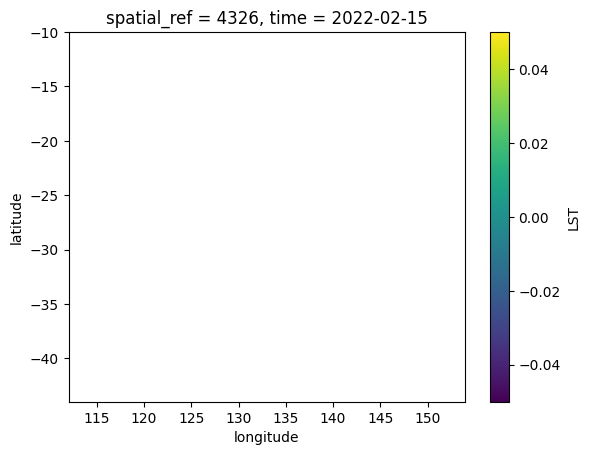

In [14]:
ds.isel(time=1).plot.imshow()

## Climate data

Temperature and VPD need to be dealt with seperately as they require multiple datasets to compute

### Rain

This runs very fast, ~6 seconds per year using 24 cores

In [ ]:
chunks=dict(latitude=250, longitude=250, time=-1)

#loop through each year
for year in years:

    clim_inputs = {
        'rain': 'OzWALD/daily/meteo/Pg/OzWALD.daily.Pg.'+year+'.nc'
         }
    
    d = {}
    for k,i in clim_inputs.items():
        
        if os.path.exists(f'{results}/{k}/{k}_5km_{year}.nc'):
            continue
        else:
            print(k, year)
        
        #open and do some prelim processing
        ds = xr.open_dataset(base+i, chunks=chunks).persist()
        ds = ds.transpose('time', 'latitude', 'longitude')
        ds = assign_crs(ds, crs='epsg:4326')
        ds = ds.to_array()
        ds = ds.squeeze().drop_vars('variable')
        ds.attrs['nodata'] = np.nan
        ds = ds.rename(k)        
        d[k] = ds #add to dict
        
    #resample time, bring into memory
    ds = d['rain'].resample(time='MS', loffset=pd.Timedelta(14, 'd')).sum().compute()

    # resample spatial
    ds = ds.odc.reproject(gbox, resampling='nearest')
    
    #tidy up
    ds = round_coords(ds)
    ds.attrs['nodata'] = np.nan
    ds = ds.rename(k)

    #mask to aus land extent
    ds = ds.where(mask)

    #export result
    folder = results+k
    if not os.path.exists(folder):
        os.makedirs(folder)

    ds.astype('float32').to_netcdf(f'{results}/{k}/{k}_5km_{year}.nc')


### Tavg

The temperature datasets are daily and 500m resolution, Tavg can only be calculated as `Tavg = Tmin + kTavg*(Tmax - Tmin)` and each variable is stored as one large netcdf per year on file (this limits parallelization in loading the datasets) so the memory and compute requirements are v. large.  

This process is so slow we need to break into up into two steps.
1. Iteratively load each of the three variables we need to calculate Tavg, reproject them to 5km resolution and save to disk
2. Calculate Tavg and save to disk

Step 1 takes ~ 87 mins per year to run using 24 cores.

Step 2. takes ~ 10-20 seconds per year

#### Step 1

In [ ]:
%%time
chunks=dict(latitude=10000, longitude=10000, time=1) #ie one chunk per time

#loop through each year
for year in years:

    clim_inputs = {
        'Tmin':'OzWALD/daily/meteo/Tmin/OzWALD.Tmin.'+year+'.nc', 
        'Tmax':'OzWALD/daily/meteo/Tmax/OzWALD.Tmax.'+year+'.nc',
        'kTavg':'OzWALD/daily/meteo/kTavg/OzWALD.kTavg.'+year+'.nc'
         }
    
    for k,i in clim_inputs.items():
        
        if os.path.exists(f'{results}/{k}/{k}_5km_{year}.nc'):
            continue
        else:
            print(k, year)
        
        #open and do some prelim processing
        ds = xr.open_dataset(base+i, chunks=chunks) # open as one chunk per time
        ds = assign_crs(ds, crs='epsg:4326')
        ds = ds.to_array()
        ds = ds.squeeze().drop_vars('variable')
        ds.attrs['nodata'] = np.nan
        #ds = ds.chunk(latitude=10000, longitude=10000, time=1) # now rechunk for the reproject
        
        #we need to spatial resample first to reduce RAM/speed up.
        if k=='kTavg':
            #upscaling from 10km to 5km
            ds = ds.odc.reproject(gbox, resampling='nearest').compute()
            ds = round_coords(ds)
        else:
            # downsacling from 500m to 5km
            ds = ds.odc.reproject(gbox, resampling='average').compute()
            ds = round_coords(ds)

        #tidy up
        ds = ds.transpose('time', 'latitude', 'longitude')
        ds = ds.rename(k)
        ds = assign_crs(ds, crs='epsg:4326')
        
        # #export result
        folder = results+k
        if not os.path.exists(folder):
            os.makedirs(folder)
        
        ds.astype('float32').to_netcdf(f'{results}/{k}/{k}_5km_{year}.nc')
        

#### Step 2

no need for dask now

In [ ]:
%%time
#loop through each year
for year in years:

    clim_inputs = {
        'Tmin':f'{results}/Tmin/Tmin_5km_{year}.nc', 
        'Tmax':f'{results}/Tmax/Tmax_5km_{year}.nc',
        'kTavg':f'{results}/kTavg/kTavg_5km_{year}.nc'
         }
    
    if os.path.exists(f'{results}/Tavg/Tavg_5km_{year}.nc'):
            continue
    else:
        print('Tavg', year)
    
    d={}
    for k,i in clim_inputs.items():
        ds = xr.open_dataarray(i)
        d[k] = ds
    
    #calculate tavg
    ds = d['Tmin'] + d['kTavg']*(d['Tmax'] - d['Tmin'])

    #resample time
    ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()
    
    #tidy up
    ds.attrs['nodata'] = np.nan
    ds = ds.rename('Tavg')

    #mask to aus land extent
    ds = ds.where(mask)

    #export result
    folder = '/g/data/os22/chad_tmp/AusEFlux/data/interim/Tavg/'
    if not os.path.exists(folder):
        os.makedirs(folder)

    ds.astype('float32').to_netcdf(f'{results}/Tavg/Tavg_5km_{year}.nc')

In [ ]:


# # NDWI = (NIR860 - NIR1240) / (NIR860 + NIR1240)
# # band5=NIR1240
# # band2=NIR860

# modis_sr_inputs = {
#         'SR_B2': 'MODIS/mosaic/MCD43A4.006/MCD43A4.006.b02.500m_0841_0876nm_nbar.'+year+'.nc',
#         'SR_B5': 'MODIS/mosaic/MCD43A4.006/MCD43A4.006.b05.500m_1230_1250nm_nbar.'+year+'.nc',
#          }

# rs_inputs = {
#         'NDVI': 'OzWALD/8day/NDVI/OzWALD.NDVI.'+year+'.nc',
#         'LST':'MODIS/mosaic/MYD11A1.006/MYD11A1.006.LST_Day_1km.'+year+'.nc',
#         'VegH': 'LandCover/OzWALD_LC/VegH_2007-2010_mosaic_AustAlb_25m.nc'
#          }

In [ ]:
# def pre_preprocess(ds, var):
#     ds = ds.transpose('latitude', 'longitude', 'time')
#     ds = assign_crs(ds, crs='epsg:4326')
#     if var=='rain':
#         ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).sum()
#     else:
#         ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()
#     ds = ds.to_array()
#     ds.attrs['nodata'] = np.nan
#     ds = ds.odc.reproject(common_grid, resampling='average')
#     ds = ds.squeeze().drop('variable')
#     ds = round_coords(ds)
#     ds.attrs['nodata'] = np.nan
#     return ds

In [ ]:
# #loop through each year
# for year in years:
    
#     modis_sr_inputs = {
#         'SR_B2': 'MODIS/mosaic/MCD43A4.006/MCD43A4.006.b02.500m_0841_0876nm_nbar.'+year+'.nc',
#         'SR_B5': 'MODIS/mosaic/MCD43A4.006/MCD43A4.006.b05.500m_1230_1250nm_nbar.'+year+'.nc',
#          }
    
#     for k,i in modis_sr_inputs.items():
         
#         print(k, year)
#         # if os.path.exists(results+k+'/'+k+'_5km_monthly_'+year+'.nc'):
#         #     print('skipping model '+name)
#         #     continue
#         # else:
#         #     print('', k)

#         # Loop through the dataset and process them
#         # Handle some datasets differently
#         different = ['WCF', 'VegH']

#         if any(k in j for j in different):
#             if k=='VegH':
#                 ds = xr.open_dataset(i, chunks=chunks)
#                 ds = ds.isel(time=-1).squeeze().drop('time') #grab any time, its all the same
                
#             if k=='WCF':    
#                 ds = xr.open_dataset(base+i, chunks=chunks)
#                 ds = ds.sel(time=year).squeeze().drop('time')
#                 ds = ds.transpose('latitude', 'longitude')
#                 ds = assign_crs(ds, crs='epsg:4326')

#             ds = ds.to_array()
#             ds.attrs['nodata'] = np.nan
#             ds = ds.odc.reproject(common_grid, resampling='average')
#             time = pd.date_range(year+"-01", year+"-12", freq='MS') 
#             time = [t+pd.Timedelta(14, 'd') for t in time]
#             ds = ds.expand_dims(time=time)
#             ds= ds.squeeze().drop('variable')
#             ds = round_coords(ds)
#             ds.attrs['nodata'] = np.nan

#         else:
#             ds = xr.open_dataset(base+i, chunks=chunks)
#             ds = pre_preprocess(ds, k)

#         ds = ds.rename(k)

#         #bring into memory
#         ds = ds.compute() 

#         #export result
#         folder = '/g/data/os22/chad_tmp/AusEFlux/data/5km/'+k

#         if not os.path.exists(folder):
#             os.makedirs(folder)

#         ds.to_netcdf(results+k+'/'+k+'_5km_monthly_'+year+'.nc')

#         del ds
